### **Classifying the Iris Data Set with Keras**

Table of Contents

Data Preperation

Visualize the Data

Configure Neural Network Models

Train the Models

Plot Accuracy and Loss from Training

Show ROC Curve

Measure Performance with Cross Validation





In this short article we will take a quick look on how to use Keras with the familiar Iris data set. We will compare networks with the regular Dense layer with different number of nodes and we will employ a Softmax activation function and the Adam optimizer.

Data Preperation
To prepare the data, we will simply use the OneHotEncoder to encode the integer features into a One-hot vector and we will use a StandardScaler to remove the mean and scale the features to unit variance. Finally we want to perform a train test split to compare our results later on.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [7]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

In [18]:
print(names)
print(feature_names)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [8]:
# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

In [9]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)

n_features = X.shape[1]
n_classes = Y.shape[1]

In [19]:
print(n_features)
print(n_classes)

4
3


### **Visualize the Data**

Let’s take a look at our data to see what we are dealing with.

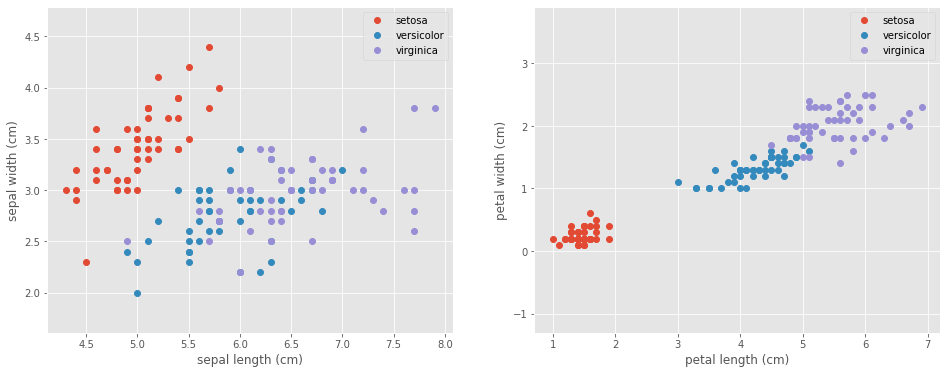

In [11]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

### **Configure Neural Network Models**

Now we configure the neural networks as discussed before and we take a look at the summary of the models.

In [12]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 4)]

create_model().summary() here gives out the model architecture.

In [13]:
for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 3)        

### **Train the Models**

Let’s now run the training. Luckily this is a short training, so we won’t have to listen to whirling fans too much. We additionally use Tensorboard as a callback if we want to explore the model and the outputs in detail.

if code is running even though there is no improvement in validation accuracy and we want to save time then we can specify the callback so that to ensure if the last 2 epochs the validation accuracy has not improved while building the deep learning model then we can specify callback that those epochs can be stopped and model iteration run only till that time up to which the validation accuracy has shown improvement from the previous iteration.

In [14]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.28844714164733887
Test accuracy: 0.9200000166893005
Model name: model_2
Test loss: 0.25942641496658325
Test accuracy: 0.9200000166893005
Model name: model_3
Test loss: 0.2684859037399292
Test accuracy: 0.9599999785423279


### **Plot Accuracy and Loss from Training**

Let’s have a look how our models perform. We can clearly see that adding more nodes makes the training perform better.

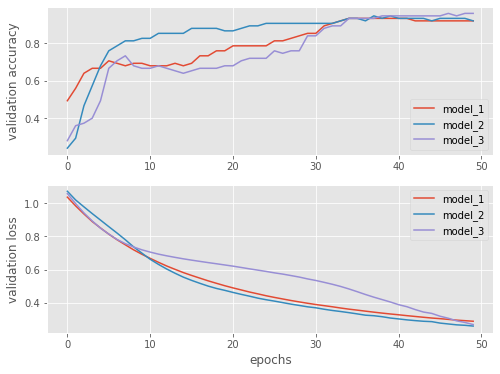

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

### **Show ROC Curve**

We have previously split the data and we can compare now with the Receiver Operating Characteristic (ROC) how well the models perform. The ROC plot compares the false positive rate with the true positive rate. We additionally compute for each model the Area under the curve (AUC), where auc = 1 is perfect classification and auc = 0.5 is random guessing (for a two class problem).

3/3 [==============================] - 0s 3ms/step


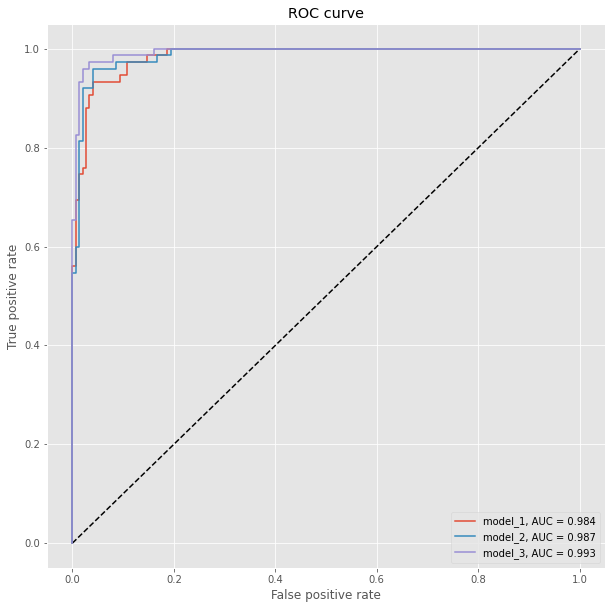

In [16]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

### **Measure Performance with Cross Validation**

Finally, we measure performance with 10-fold cross validation for the model_3 by using the KerasClassifier which is a handy Wrapper when using Keras together with scikit-learn. In this case we use the full data set.

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

create_model = create_custom_model(n_features, n_classes, 8, 3)

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
scores = cross_val_score(estimator, X_scaled, Y, cv=10)
print("Accuracy : {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))

Accuracy : 0.93 (+/- 0.08)


In [21]:
!jupyter nbconvert keras_iris.ipynb

[NbConvertApp] Converting notebook keras_iris.ipynb to html
[NbConvertApp] Writing 443479 bytes to keras_iris.html
